# Day 2: Supply I

We talked today about how electricity markets work.

We will learn today how to simplify hourly data from electricity markets.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries.

Compared to day 1, we will be adding the the clustering library `Clustering`.


In [2]:
using Pkg
Pkg.add(["DataFrames", "CSV", "Clustering", "Plots", "StatsPlots", "Statistics", "StatsBase", "Printf", "Random", "FixedEffectModels"])

In [3]:
using DataFrames
using CSV
using Clustering
using Plots
using StatsPlots
using Statistics, StatsBase
using Printf
using Random
using FixedEffectModels

In [ ]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2024/day2/practicum/"

We load the data using the CSV syntax (`CSV.read`) into a data frame called `df`.  Here we need to do some cleaning of the variables, rescaling and dropping missing entries. Make sure the data is in the same directory as the notebook or specify the full path name.

In [ ]:
# We read the data and clean it up a bit
df = CSV.read("data_jaere.csv", DataFrame)
df = sort(df,["year","month","day","hour"])
df = dropmissing(df)
df.nuclear = df.nuclear/1000.0
df.hydro = df.hydro/1000.0
df.imports = df.imports/1000.0
df.q_commercial = df.q_commercial/1000.0
df.q_industrial = df.q_industrial/1000.0
df.q_residential = df.q_residential/1000.0
df.hydronuc = df.nuclear + df.hydro 
df = select(df,Not(["nuclear","hydro"]))
first(df, 5)

In [ ]:
df

In [ ]:
describe(df)

In [ ]:
plot(rownumber.(eachrow(df)),df.hydronuc)

In [ ]:
plot(rownumber.(eachrow(df)),df.price)

## Clustering our data

When modeling electricity markets, oftentimes the size of the problem can make the solver slow.

Here we will be using a clustering algorithm to come up with a (much) smaller synthetic dataset that we will use for the purposes of our main analysis.

**Note:** We ignore the time variables when we cluster.

In [ ]:
n = 500
X = transpose(Array(select(df,Between(:price,:hydronuc))));

# We scale variables to improve kmeans performance. For that, we take the mean and std of each row (dim=2) and you repeat it by the number of columns (rows in df)
Xs = (X.- repeat(mean(X,dims=2),1,nrow(df)))./repeat(std(X,dims=2),1,nrow(df)); 

#we set seed because kmeans picks random samples to generate clusters
Random.seed!(2020)
R = kmeans(Xs, n);

# Get the cluster centers rescaling again
M = R.centers .* repeat(std(X,dims=2),1,n) .+ repeat(mean(X,dims=2),1,n);  

# R = kmeans(X, n);
# M = R.centers; 


In [ ]:
dfclust = DataFrame(transpose(M),
["price", "imports", "q_commercial", "q_industrial", "q_residential", 
        "wind_cap", "solar_cap", "hydronuc"]);
dfclust.weights = counts(R);
first(dfclust, 5)

In [ ]:
dfclust.weights

In [ ]:
dfclust

We can compare the distribution of outcomes between the original dataset and the new dataset.

Here is an example with prices. The two distributions are very similar.

In [ ]:
histogram(df.price, fillalpha=.2, nbins=20, label="Data")
histogram!(dfclust.price, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

In [ ]:
histogram(df.solar_cap, fillalpha=.2, nbins=20, label="Original")
histogram!(dfclust.solar_cap, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

We can also check that the correlation between the main variables of interest remains similar.


In [ ]:
# with original data
@df df cornerplot(cols([:price, :imports,:wind_cap,:solar_cap]), grid = false, compact=true)

In [ ]:
# with synthetic data, note issue that weights are not allowed in Julia function
@df dfclust cornerplot(cols([:price, :imports,:wind_cap,:solar_cap]), grid = false,compact = true, weights = :weights)

We can visualize the correlations directly, allowing for a correction for weights. 

We can see that the overall correlation patterns are quite good, capturing mot of the relationships in the data accurately.

In [ ]:
MatOriginal = cor(Array(select(df,[:price,:imports,:wind_cap,:solar_cap])))

In [ ]:
MatClust = cor(Array(select(dfclust,[:price, :imports,:wind_cap,:solar_cap])), Weights(dfclust.weights))

In [ ]:
heatmap(MatOriginal)

In [ ]:
heatmap(MatClust)

We can check how the correlation of solar and price depend on controls.

In [ ]:
reg_nocontrols = reg(df, @formula(price ~ solar_cap))

In [ ]:
reg_controls = reg(df, @formula(price ~ solar_cap + q_commercial + q_residential + q_industrial))

We save the clustered data.

In [ ]:
CSV.write(string(dirpath,"data_jaere_clustered_",n,".csv"), dfclust)

## Follow-up exercises (note: this will be in problem set)

1. Perform the same clustering exercise with the wind data from Spain that we used last week.


In [4]:
df = CSV.read("C:/Users/Juan Acuña/Desktop/BSE/T2/QSM II/Practicum/day1_data_spain.csv", DataFrame)
describe(df)

n = 500
df_clean = dropmissing(df)

X = transpose(Array(select(df_clean,Between(:demand,:emis_tCO2))));

# We scale variables to improve kmeans performance. For that, we take the mean and std of each row (dim=2) and you repeat it by the number of columns (rows in df)
Xs = (X .- repeat(mean(X, dims=2), 1, nrow(df_clean))) ./ repeat(std(X, dims=2), 1, nrow(df_clean)); 

#we set seed because kmeans picks random samples to generate clusters
Random.seed!(2020)
R = kmeans(Xs, n; maxiter=100, display=:none);

# Get the cluster centers rescaling again
M = R.centers .* repeat(std(X, dims=2), 1, n) .+ repeat(mean(X, dims=2), 1, n);  

# R = kmeans(X, n);
# M = R.centers; 

dfclust = DataFrame(transpose(M),
["demand", "demand_forecast", "wind", "wind_forecast", "wholesale_price", 
        "system_costs", "emis_tCO2"]);
				
dfclust.weights = counts(R);
first(dfclust, 5)

Row,demand,demand_forecast,wind,wind_forecast,wholesale_price,system_costs,emis_tCO2,weights
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,30.8348,30.8529,8.66547,7.95711,57.0369,4.62727,6732.11,150
2,31.2349,31.4249,1.45471,1.54518,56.7408,2.49443,6209.91,115
3,38.1483,38.2239,6.35991,6.24912,52.9855,1.7096,10412.5,126
4,24.6119,24.5361,10.7132,10.3892,31.117,4.55034,5815.49,146
5,21.3546,21.3879,4.7805,4.66749,37.1054,4.75134,3748.39,217


In [ ]:
dfclust.weights

In [ ]:
dfclust

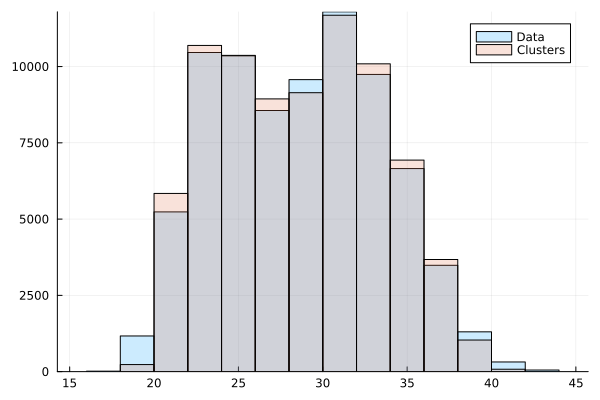

In [5]:
histogram(df.demand, fillalpha=.2, nbins=20, label="Data")
histogram!(dfclust.demand, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

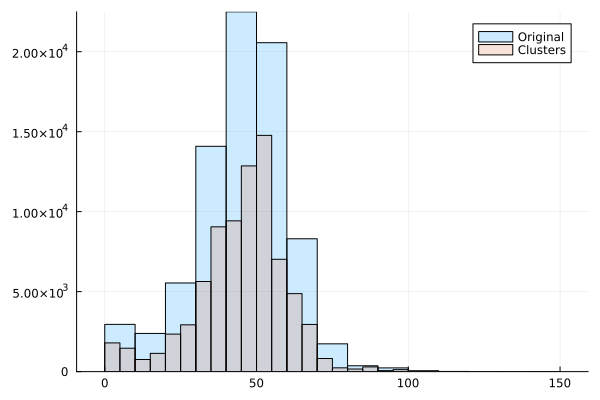

In [6]:
histogram(df.wholesale_price, fillalpha=.2, nbins=20, label="Original")
histogram!(dfclust.wholesale_price, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

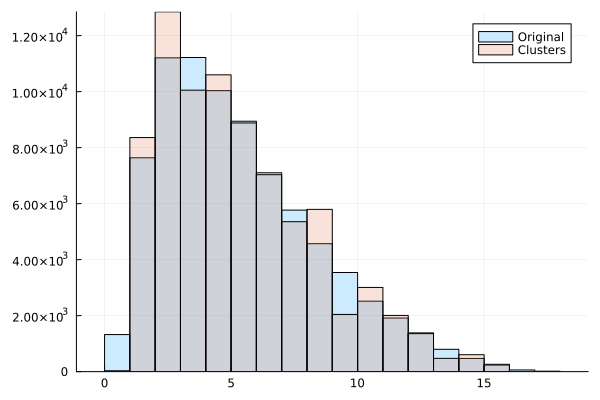

In [7]:
histogram(df.wind, fillalpha=.2, nbins=20, label="Original")
histogram!(dfclust.wind, weights=dfclust.weights, fillalpha=.2, nbins=20, label="Clusters")

In [ ]:
@df df_clean cornerplot(cols([:demand,:wind,:wholesale_price,:emis_tCO2]), grid = false, compact=true)



2. Can you run regressions that give you a similar answer with as little as 100 or 200 observations? Note: It is essential that you use a *weighted regression*.


In [ ]:
describe(df)